In [1]:
import os, sys, numpy as np, cv2
from scipy import signal
from skimage.util import img_as_float
from skimage.io import imread
from skimage import color
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

%matplotlib inline

Running detector:


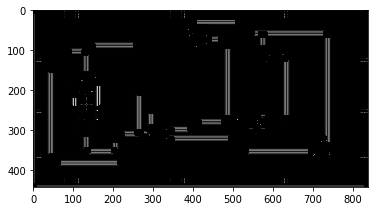

In [40]:
def bilinear_interpolation(x, y, mag):
    px, nx = int(np.floor(x)), int(np.ceil(x))
    py, ny = int(np.floor(y)), int(np.ceil(y))
    return (x-px)*(y-py)*mag[py,px] + (x-px)*(ny-y)*mag[ny,px] + (nx-x)*(y-py)*mag[py,nx] + (nx-x)*(ny-y)*mag[ny,nx]


def compute_edges_dxdy(I):
    """Returns the norm of dx and dy as the edge response function."""
    threshold = 1.5

    I = I.astype(np.float32)/255.
    I = gaussian_filter(I, sigma=2, mode='mirror')
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary='symm')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary='symm')
    mag = np.sqrt(dx**2 + dy**2)

    mag = mag / np.max(mag)
    mag = mag * 255.
    mag = np.clip(mag, 0, 255)
    mag = mag.astype(np.uint8)

    sup_mag = np.copy(mag)

    m, n = mag.shape
    for i in range(m-1):
        for j in range(n-1):
            py, ny = i - dy[i, j], i + dy[i, j]
            px, nx = j - dx[i, j], j + dx[i, j]
            if mag[i, j] < threshold*bilinear_interpolation(px, py, mag) or mag[i, j] < threshold*bilinear_interpolation(nx, ny, mag):
                sup_mag[i, j] = 0
    return sup_mag

def detect_edges(I, fn):
    gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    mag = fn(gray)
    plt.imshow(mag, cmap='gray')

print('Running detector:')
fn = compute_edges_dxdy
detect_edges(cv2.imread('./pcb_image_1.png'), fn)

# Checking if different kernels for line detection would work

In [21]:
kernel_horiz = np.array([[-1]*3, [2]*3, [-1]*3])
kernel_verti = kernel_horiz.T
kernel_diag1 = np.array([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]])
kernel_diag2 = np.array([[2, -1, -1], [-1, 2, -1], [-1, -1, 2]])

In [4]:
def convolve(img, kernel):
    m1, n1 = img.shape[:2]
    m2, n2 = kernel.shape[:2]
    convolved = np.zeros(img.shape)
    for i in range(m1-m2):
        for j in range(n1-n2):
            convolved[i, j] = np.sum(img[i:i+m2, j:j+n2]*kernel)
    return convolved

In [5]:
def get_gray_norm_image(path):
    orig_img = imread(path)
    gray_img = color.rgb2gray(orig_img)
    norm_img = gray_img/255.
    return norm_img

img = get_gray_norm_image('./pcb_image_1.png')

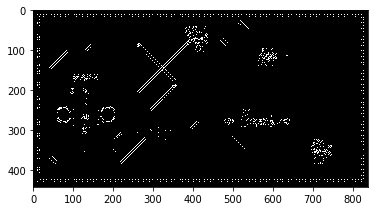

In [18]:
convolved_diag1 = convolve(img, kernel_diag1)
plt.imshow(np.where(convolved_diag1 > 0, 1 , 0), cmap='gray')

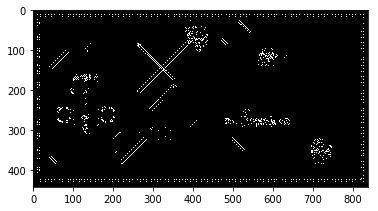

In [23]:
convolved_diag2 = convolve(img, kernel_diag2)
plt.imshow(np.where(convolved_diag2 > 0, 1, 0), cmap='gray')

# Checking hough transform

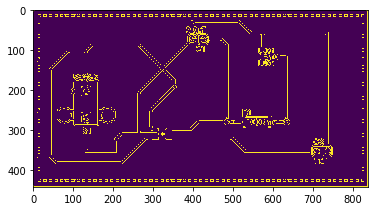

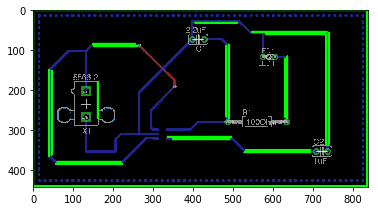

In [88]:
def hough_transform(img, out_img_name):
    if isinstance(img, str):
        img = cv2.imread(img)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150,apertureSize = 7)
    plt.imshow(edges)
    minLineLength = 100
    maxLineGap = 80
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
#     for x1,y1,x2,y2 in lines[0]:
#         cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

    a,b,c = lines.shape
    for i in range(a):
        cv2.line(img, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 255, 0), 3, cv2.LINE_AA)
    
    cv2.imwrite(out_img_name, img)

hough_transform('./pcb_image_1.png', './pcb_image_1_out.png')
plt.figure()
plt.imshow(cv2.imread('./pcb_image_1_out.png'))

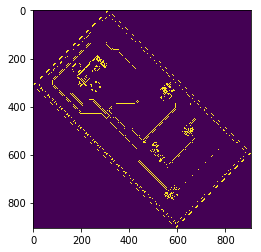

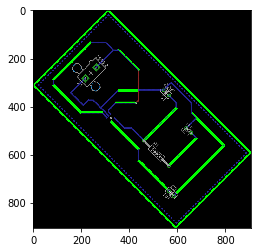

In [90]:
rotated_img1 = ndimage.rotate(upright_img, -45)
hough_transform(rotated_img1, './pcb_image_1_out_experiment.png')
plt.figure()
plt.imshow(cv2.imread('./pcb_image_1_out_experiment.png'))

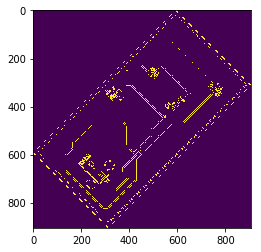

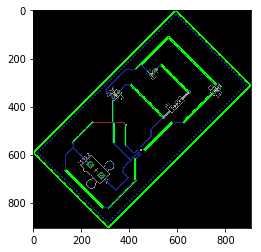

In [92]:
rotated_img1 = ndimage.rotate(upright_img, 45)
hough_transform(rotated_img1, './pcb_image_1_out_experiment2.png')
plt.figure()
plt.imshow(cv2.imread('./pcb_image_1_out_experiment2.png'))